In [136]:
# KAGGLE DIGIT RECOGNITION USING LOGISTIC REGRESSION.
# ACCURACY ON KAGGLE TRAINING SET : 1.0 (OVERFITTED).
# ACCURACY ON CROSS VALIDATION SET : 97642.
# ACCURACY ON KAGGLE TEST SET : 0.97742.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pandas import DataFrame as df
from pandas import Series as sr

from sklearn.model_selection import StratifiedShuffleSplit as strat
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures

import warnings
warnings.filterwarnings('ignore') # IGNORE DEPRECATION (AND OTHER WARNINGS).

In [137]:
# IMPORTING DATA.
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [138]:
features = train.copy()
labels = train['label']
test_features = test.copy()

In [139]:
features.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [140]:
print(features.shape, labels.shape)

(42000, 785) (42000,)


In [141]:
# SPLITTING ORIGINAL TRAINING DATA INTO TRAINING AND VALIDATION DATA IN A STRATIFIED MANNER.
split = strat(test_size=0.2, random_state=42)
for train_indices, valid_indices in split.split(features, features['label']):
    strat_train = features.loc[train_indices]
    strat_valid = features.loc[valid_indices]

In [146]:
# BOTH TRAINING AND VALIDATION SETS ARE STRATIFIED.
print('DIGIT      ORIGINAL           TRAINING             VALIDATION')
for i in range(10) :
    print(i, '   ', (features['label'] == i).sum() / len(features), \
                    (strat_train['label'] == i).sum() / len(strat_train), \
                    (strat_valid['label'] == i).sum() / len(strat_valid))

DIGIT      ORIGINAL           TRAINING             VALIDATION
0     0.09838095238095237 0.09836309523809524 0.09845238095238096
1     0.11152380952380953 0.11151785714285714 0.11154761904761905
2     0.09945238095238096 0.09946428571428571 0.0994047619047619
3     0.1035952380952381 0.10360119047619047 0.10357142857142858
4     0.09695238095238096 0.09696428571428571 0.09690476190476191
5     0.09035714285714286 0.09035714285714286 0.09035714285714286
6     0.0985 0.09851190476190476 0.09845238095238096
7     0.10478571428571429 0.10479166666666667 0.10476190476190476
8     0.09673809523809523 0.09672619047619048 0.09678571428571428
9     0.09971428571428571 0.09970238095238096 0.09976190476190476


In [147]:
# PREPARING DATA.
strat_train_x = strat_train.copy()
strat_train_x.drop(['label'], axis=1, inplace=True)
strat_train_y = strat_train['label']

strat_valid_x = strat_valid.copy()
strat_valid_x.drop(['label'], axis=1, inplace=True)
strat_valid_y = strat_valid['label']

In [148]:
# CONVERTING ALL DATAFRAMES TO NUMPY ARRAYS FOR FAST COMPUTATIONS.
strat_train_x = np.array(strat_train_x)
strat_train_y = np.array(strat_train_y)
strat_valid_x = np.array(strat_valid_x)
strat_valid_y = np.array(strat_valid_y)
test_features = np.array(test_features)
print(strat_train_x.shape, strat_train_y.shape, strat_valid_x.shape, strat_valid_y.shape, \
     test_features.shape)

(33600, 784) (33600,) (8400, 784) (8400,) (28000, 784)


In [150]:
def plot_images(images, true, pred=None):
    figure = plt.figure( figsize = ( 15, 15 ) )

    for i in range(len(images)) :
        ax = figure.add_subplot( 3, 3, i + 1 )
        ax.imshow( images[i, :].reshape(28, 28), cmap = 'binary' )
        if pred is None:
            ax.set_xlabel('True Label : {0}'.format(np.argmax(true[i])))
        else:
            ax.set_xlabel('True Label : {0}, Prediction : {1}'.format(true[i], pred[i]))
        ax.set_xticks([])
        ax.set_yticks([])

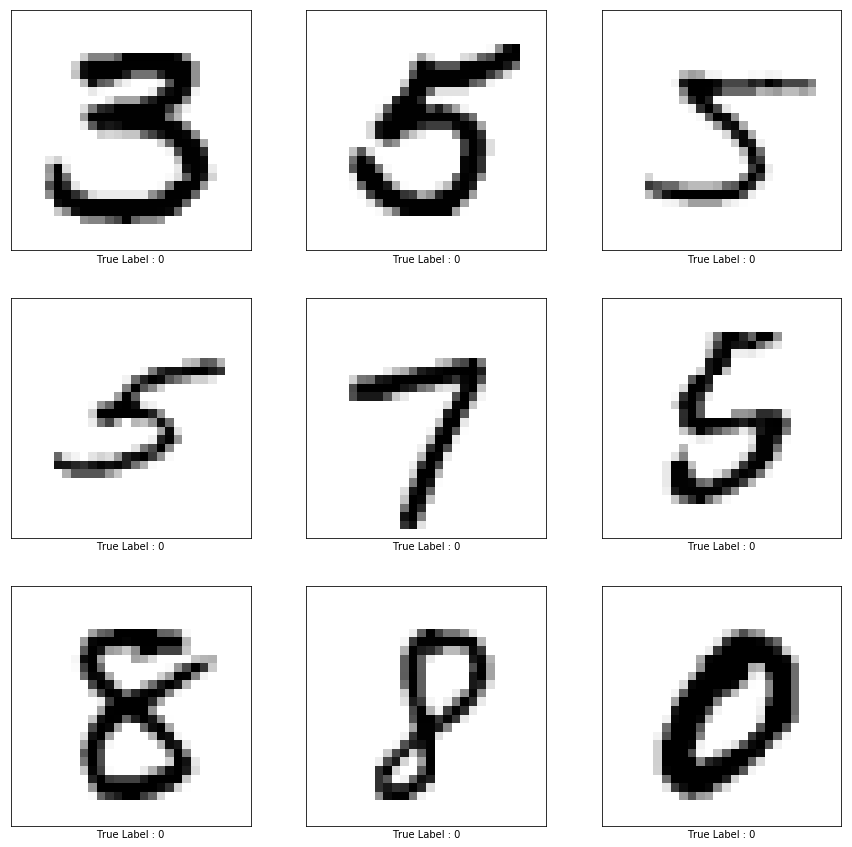

In [151]:
# PLOTTING FIRST NINE IMAGES WITH TRUE LABELS.
plot_images(strat_train_x[0:9, :], strat_train_y[0:9]) 

In [152]:
# COUNTS OF EACH DIGIT IN THE TRAINING SET.
label_counts = labels.value_counts()
label_counts.sort_index(inplace=True)
label_counts

0    4132
1    4684
2    4177
3    4351
4    4072
5    3795
6    4137
7    4401
8    4063
9    4188
Name: label, dtype: int64

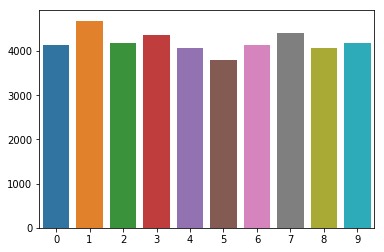

In [153]:
sns.barplot(x=list(range(0,10)), y=list(label_counts))

In [154]:
# CASTING VALUES TO FLOATS SO THAT THEY CAN BE NORMALISED.
strat_train_x = strat_train_x.astype('float32')
strat_valid_x = strat_valid_x.astype('float32')
test_features = test_features.astype('float32')

# NORMALISING ALL THE FEATURE VALUES.
strat_train_x /= 255 
strat_valid_x /= 255
test_features /= 255
# FIRST TIME I HAD USED STANDARD SCALING 'from sklearn.preprocessing import StandardScaler' BUT IT 
# GAVE LESS ACCURACY THAN NORMALISING IN THIS WAY. 

In [156]:
# APPLYING LOGISTIC REGRESSSION DIRECTLY USING 'lbfgs' AS SOLVER.
def direct(max_iter):
    log_direct = LogisticRegression(solver='lbfgs', max_iter=max_iter)
    log_direct_model = log_direct.fit(strat_train_x, strat_train_y)
    return log_direct

max_iter_values = [10, 100, 200]
pred_test = []

for max_iter in max_iter_values:
    print('Iterating :', max_iter, ' times.')
    print('--------------------------------------------------------------------------------------')
    log_direct = direct(max_iter)
    
    pred_train = log_direct.predict(strat_train_x)
    pred_valid = log_direct.predict(strat_valid_x)
    pred_test.append(log_direct.predict(test_features))
    
    acc_train = (pred_train == strat_train_y).mean()
    cm_train = metrics.confusion_matrix(strat_train_y, pred_train)
    print('Training Set Metrics\n')
    print(acc_train)
    print(cm_train)
    print('\n')
    
    acc_valid = (pred_valid == strat_valid_y).mean()
    cm_valid = metrics.confusion_matrix(strat_valid_y, pred_valid)
    print('Validation Set Metrics\n')
    print(acc_valid)
    print(cm_valid)
    print('\n--------------------------------------------------------------------------------------')
    print('\n\n')

Iterating : 10  times.
--------------------------------------------------------------------------------------
Training Set Metrics

0.8990178571428571
[[3222    1    2    5    9   14   24    2   23    3]
 [   1 3646   12   17    2   14    9    6   37    3]
 [  23   37 2920   43   69   10   45   68  105   22]
 [  13   28   99 3055    7   90   30   38   80   41]
 [   4   19   29    8 2966    6   29    7   40  150]
 [  52   26   26  173   57 2345   85   21  191   60]
 [  28    5   15    3   26   35 3173    2   21    2]
 [  18   46   54   12   38    8    3 3225    5  112]
 [  31   90   39   99   24  114   26   26 2757   44]
 [  29   16   13   65  135   29    2  128   35 2898]]


Validation Set Metrics

0.8910714285714286
[[802   0   3   4   1   4   5   1   5   2]
 [  0 912   5   1   0   4   3   2   9   1]
 [  8  13 711   9  15   1  21  19  30   8]
 [  5   5  24 753   0  35  15   7  21   5]
 [  5   4   7   1 730   0   9   3  13  42]
 [ 19  10   0  50  24 583  22   5  32  14]
 [  5   3   7  

In [160]:
# AS IT CAN BE OBSERVED THAT ACCURACY IS NOT INCREASING BY MUCH.
# SO NOW CHECKING FOR THOSE FEATURES WHICH ARE PROVIDING THE MAXIMUM VARIANCES.
variances = np.var(strat_train_x, axis=0)

In [161]:
# RATIO OF A FEATURE'S VARIANCE TO THE TOTAL VARIANCE IS MUCH MORE INFORMATIVE AND WILL HELP IN 
# SELECTING THE MINIMUM NUMBER OF FEATURES WITH MAXIMUM OVERALL VARIANCE.
variances_ratios = variances / variances.sum()
variances_ratios = np.sort(variances_ratios)[::-1] # SORTING IN DESCENDING ORDER.
print(variances.sum())

52.805534


In [162]:
variances_ratios_cum = [np.sum(variances_ratios[0:x+1]) for x in range(len(variances_ratios))]

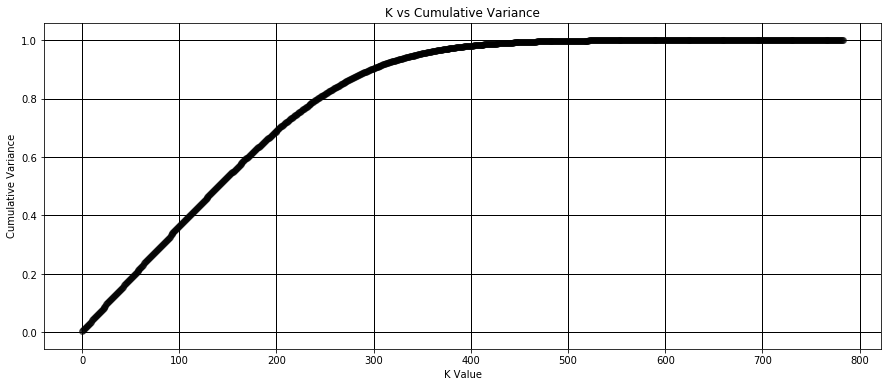

In [163]:
# GRAPH OF NUMBER OF FEATURES(K) VS CUMMULATIVE VARIANCE.
figure = plt.figure(figsize=(15, 6))

plt.grid(color='k', linestyle='-', linewidth=1)
plt.xlabel('K Value')
plt.ylabel('Cumulative Variance')
plt.title('K vs Cumulative Variance')
plt.scatter(range(len(variances_ratios_cum)), variances_ratios_cum, alpha=0.5, color='k')

In [164]:
# 80% OF THE COMBINED VARIANCE IS COVERED BY JUST 250 FEATURES.
# APPLYING PCA FOR DIMENSIONALITY REDUCTION TO 250 FEATURES.
pca_250 = PCA(n_components=250, whiten=True)
pca_250_fit = pca_250.fit(strat_train_x)

strat_train_x_pca_250 = pca_250_fit.transform(strat_train_x)
strat_valid_x_pca_250 = pca_250_fit.transform(strat_valid_x)
test_features_pca_250 = pca_250_fit.transform(test_features)

In [165]:
# NOW APPLYING LOGISTIC REGRESSSION USING 'lbfgs' AS SOLVER.
def log_reg_pca_250(max_iter):
    log_pca_250 = LogisticRegression(solver='lbfgs', max_iter=max_iter)
    log_pca_250_model = log_pca_250.fit(strat_train_x_pca_250, strat_train_y)
    return log_pca_250

max_iter_values_pca_250 = [10, 100, 200]
pred_test_pca_250 = []

for max_iter in max_iter_values_pca_250:
    print('Iterating :', max_iter, ' times.')
    print('--------------------------------------------------------------------------------------')
    log_pca_250 = log_reg_pca_250(max_iter)
    
    pred_train_pca_250 = log_pca_250.predict(strat_train_x_pca_250)
    pred_valid_pca_250 = log_pca_250.predict(strat_valid_x_pca_250)
    pred_test_pca_250.append(log_pca_250.predict(test_features_pca_250))
    
    acc_train = (pred_train_pca_250 == strat_train_y).mean()
    cm_train = metrics.confusion_matrix(strat_train_y, pred_train_pca_250)
    print('Training Set Metrics\n')
    print(acc_train)
    print(cm_train)
    print('\n')
    
    acc_valid = (pred_valid_pca_250 == strat_valid_y).mean()
    cm_valid = metrics.confusion_matrix(strat_valid_y, pred_valid_pca_250)
    print('Validation Set Metrics\n')
    print(acc_valid)
    print(cm_valid)
    print('\n--------------------------------------------------------------------------------------')
    print('\n\n')

Iterating : 10  times.
--------------------------------------------------------------------------------------
Training Set Metrics

0.923422619047619
[[3238    1    3    2    5   12   20    2   18    4]
 [   0 3664   10   14    2   11    4    7   34    1]
 [  14   29 3016   48   43   24   26   43   82   17]
 [   8   22   87 3107    4   98   16   30   69   40]
 [   6   19   20    8 3048    3   21   10   29   94]
 [  42   20   19   95   32 2653   52   17   77   29]
 [  21    9    9    2   13   45 3191    4   14    2]
 [  11   29   45   10   22    7    5 3285    6  101]
 [  25   69   26   79   27   89   19   22 2846   48]
 [  19   11    9   57   96   32    0  110   37 2979]]


Validation Set Metrics

0.9075
[[800   0   2   3   3   7   4   1   5   2]
 [  0 912   5   2   0   3   3   1  10   1]
 [  8  13 742  14  10   6   9   9  22   2]
 [  5   5  21 759   2  39   6   9  20   4]
 [  3   4   6   3 744   3   5   3   9  34]
 [ 14   4   2  36  16 636  17   2  21  11]
 [  2   3   3   1   6  12 78

In [169]:
# ACCURACY IS NOT GOING ABOVE 92%.
# POLYNOMIAL FEATURES CAN BE USED TO INCREASE THE MODEL'S LEARNING POWER AND THUS ACCURACY BUT WITH 
# 250 FEATURES THERE WILL BE MANY POLYNOMIAL FEATURES MAKING IT VERY TIME TAKING TO TRAIN.
# INSTEAD WE WILL CHOOSE 50 BEST FEATURES AND APPLY POLYNOMIAL FEATURES.
pca = PCA(n_components=50, whiten=True)
pca_fit = pca.fit(strat_train_x)

strat_train_x_pca = pca_fit.transform(strat_train_x)
strat_valid_x_pca = pca_fit.transform(strat_valid_x)
test_features_pca = pca_fit.transform(test_features)

poly = PolynomialFeatures(include_bias=False) # 'incude_bias=False' BECAUSE LOGISTIC REGRESSION
                                              # ITSELF ADDS A BIAS COLUMN.
strat_train_x_pca_poly = poly.fit_transform(strat_train_x_pca)
strat_valid_x_pca_poly = poly.fit_transform(strat_valid_x_pca)
test_features_pca_poly = poly.fit_transform(test_features_pca)

In [172]:
# NOW APPLYING LOGISTIC REGRESSSION USING 'lbfgs' AS SOLVER ON POLYNOMIAL FEATURES.
def log_reg(max_iter):
    log = LogisticRegression(solver='lbfgs', max_iter=max_iter)
    log_model = log.fit(strat_train_x_pca_poly, strat_train_y)
    return log

max_iter_values_pca = [10, 50, 100]
pred_test_pca_arr = []

for max_iter in max_iter_values_pca:
    print('Iterating :', max_iter, ' times.')
    print('--------------------------------------------------------------------------------------')
    log = log_reg(max_iter)
    
    pred_train_pca = log.predict(strat_train_x_pca_poly)
    pred_valid_pca = log.predict(strat_valid_x_pca_poly)
    pred_test_pca = log.predict(test_features_pca_poly)
    pred_test_pca_arr.append(pred_test_pca)
    
    acc_train = (pred_train_pca == strat_train_y).mean()
    cm_train = metrics.confusion_matrix(strat_train_y, pred_train_pca)
    print('Training Set Metrics\n')
    print(acc_train)
    print(cm_train)
    print('\n')
    
    acc_valid = (pred_valid_pca == strat_valid_y).mean()
    cm_valid = metrics.confusion_matrix(strat_valid_y, pred_valid_pca)
    print('Validation Set Metrics\n')
    print(acc_valid)
    print(cm_valid)
    print('\n--------------------------------------------------------------------------------------')
    print('\n\n')

Iterating : 10  times.
--------------------------------------------------------------------------------------
Training Set Metrics

0.9918154761904762
[[3299    0    1    0    0    0    4    0    0    1]
 [   0 3736    1    0    2    0    1    5    2    0]
 [   1    2 3326    1    3    0    0    5    2    2]
 [   1    0    8 3441    0   12    0    4    6    9]
 [   0    6    1    0 3228    0    2    2    2   17]
 [   3    1    0    7    0 3009    8    0    3    5]
 [   3    1    0    0    1    5 3299    0    1    0]
 [   0   10    5    0    3    1    0 3488    2   12]
 [   2    9    4    4    5    7    3    1 3210    5]
 [   1    0    2    7   15    4    0   23    9 3289]]


Validation Set Metrics

0.9751190476190477
[[814   0   0   3   1   0   3   1   4   1]
 [  0 925   6   0   0   0   0   3   2   1]
 [  1   1 809   3   3   1   0   7   9   1]
 [  1   0   7 842   0  10   1   1   5   3]
 [  1   3   1   0 796   0   3   1   2   7]
 [  3   0   1   7   0 738   0   1   2   7]
 [  1   0   1  

In [174]:
# CLEARLY THE MODEL HAS OVERFITTED.
# SUBMITTING THE PRECTIONS ON TEST SET TO KAGGLE.

# SUBMITTING pred_test_pca[0].
ids = range(1, len(pred_test_pca_arr[0])+1)
output = pd.DataFrame({"ImageId": ids , "Label": pred_test_pca_arr[0] })
output.to_csv('output_0.csv', index=False)
# ACCURACY : 0.97642.

# SUBMITTING pred_test_pca[1].
output = pd.DataFrame({"ImageId": ids , "Label": pred_test_pca_arr[1] })
output.to_csv('output_1.csv', index=False)
# ACCURACY : 0.97657.

# SUBMITTING pred_test_pca[2].
output = pd.DataFrame({"ImageId": ids , "Label": pred_test_pca_arr[2] })
output.to_csv('output_2.csv', index=False)
# ACCURACY : 0.97742.